In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def im2col(x, f_h, f_w, padding=1, stride=1):
    m, H, W, C = x.shape
    H_out = (H + 2 * padding - f_h) // stride + 1
    W_out = (W + 2 * padding - f_w) // stride + 1
    x_padded = np.pad(x, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')
    col = np.zeros((m, H_out, W_out, f_h, f_w, C))
    for y in range(f_h):
        y_max = y + stride * H_out
        for x_idx in range(f_w):
            x_max = x_idx + stride * W_out
            col[:, :, :, y, x_idx, :] = x_padded[:, y:y_max:stride, x_idx:x_max:stride, :]
    col = col.reshape(m * H_out * W_out, f_h * f_w * C)
    return col, H_out, W_out

In [28]:
def col2im(dx_col, x_shape, f_h, f_w, padding=1, stride=1):
    m, H, W, C = x_shape
    H_out = (H + 2 * padding - f_h) // stride + 1
    W_out = (W + 2 * padding - f_w) // stride + 1
    dx_padded = np.zeros((m, H + 2 * padding, W + 2 * padding, C))
    dx_col_reshaped = dx_col.reshape(m, H_out, W_out, f_h, f_w, C)
    for y in range(f_h):
        y_max = y + stride * H_out
        for x_idx in range(f_w):
            x_max = x_idx + stride * W_out
            dx_padded[:, y:y_max:stride, x_idx:x_max:stride, :] += dx_col_reshaped[:, :, :, y, x_idx, :]
    if padding > 0:
        dx = dx_padded[:, padding:-padding, padding:-padding, :]
    else:
        dx = dx_padded
    return dx

In [29]:
def fast_convolution(x, W, b, padding=1, stride=1):
    m, H, W_in, C = x.shape
    f_h, f_w, _, num_filters = W.shape

    x_col, H_out, W_out = im2col(x, f_h, f_w, padding, stride)
    W_col = W.reshape(f_h * f_w * C, num_filters)

    out = x_col @ W_col + b
    out = out.reshape(m, H_out, W_out, num_filters)
    
    return out

In [30]:
def fast_convolution_backprop(x, W, b, dout, padding=1, stride=1):
    m, H, W_in, C = x.shape
    f_h, f_w, _, num_filters = W.shape

    x_col, H_out, W_out = im2col(x, f_h, f_w, padding, stride)

    dout_reshaped = dout.reshape(m * H_out * W_out, num_filters)
    dW_col = x_col.T @ dout_reshaped

    dW = dW_col.reshape(W.shape)
    db = np.sum(dout_reshaped, axis=0, keepdims=True)
    W_col = W.reshape(f_h * f_w * C, num_filters)
    dx_col = dout_reshaped.dot(W_col.T)
    
    dx = col2im(dx_col, x.shape, f_h, f_w, padding, stride)
    return dx, dW, db

In [31]:
m = 200
H = W = 244
C = 1
np.random.seed(42)
X = np.random.randn(m, H, W, C)
X = (X - np.min(X)) / (np.max(X) - np.min(X))

In [32]:
f_h, f_w = 3, 3
num_filters = 4
padding = 1
stride = 1
W_conv = np.random.randn(f_h, f_w, C, num_filters) * 0.1
b_conv = np.zeros((1, num_filters))

Forma de la salida (forward): (200, 244, 244, 4)


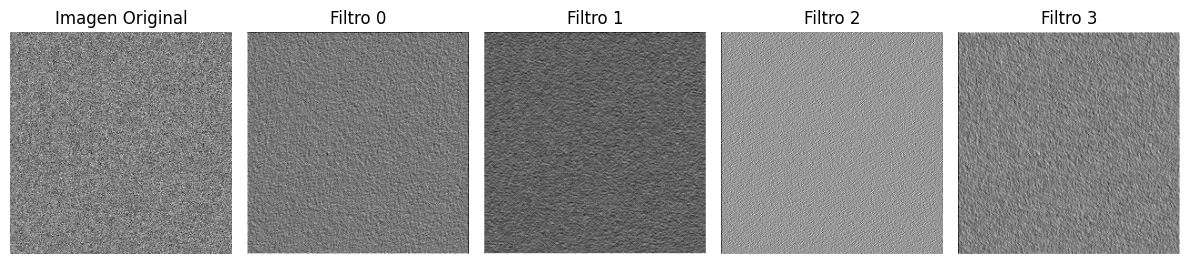

In [33]:

out_fast = fast_convolution(X, W_conv, b_conv, padding, stride)
print("Forma de la salida (forward):", out_fast.shape)

plt.figure(figsize=(12, 3))
plt.subplot(1, num_filters + 1, 1)
plt.imshow(X[0, :, :, 0], cmap='gray')
plt.title("Imagen Original")
plt.axis('off')
for f in range(num_filters):
    plt.subplot(1, num_filters + 1, f + 2)
    plt.imshow(out_fast[0, :, :, f], cmap='gray')
    plt.title(f"Filtro {f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [34]:
dout = np.random.randn(*out_fast.shape)
dx, dW, db = fast_convolution_backprop(X, W_conv, b_conv, dout, padding, stride)
print("Forma de dx:", dx.shape)
print("Forma de dW:", dW.shape)
print("Forma de db:", db.shape)

Forma de dx: (200, 244, 244, 1)
Forma de dW: (3, 3, 1, 4)
Forma de db: (1, 4)
